# LSTM for Air Passenger Prediction: A Beginner-Level Exploration

## Introduction

This project aims to develop a beginner-level model utilizing Long Short-Term Memory (LSTM) neural networks for forecasting the number of air passengers. The Air Passenger dataset contains monthly totals of airline passengers from 1949 to 1960, providing a rich historical context for analysis. By leveraging LSTM's ability to learn complex temporal dependencies, we can predict future passenger counts based on past trends. This project offers valuable insights into seasonal patterns and fluctuations in the air transportation industry, making it a vital tool for stakeholders in the field.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objs as go

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, SimpleRNN  
from sklearn.preprocessing import MinMaxScaler  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data

In [2]:
data = '/kaggle/input/air-passengers/AirPassengers.csv'

df = pd.read_csv(data)

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.rename(columns={'#Passengers':'passengers'},inplace=True)
# Since this is a time series, we need only second column.. So data now contains only passenger count...
df = df['passengers']

# Visualization

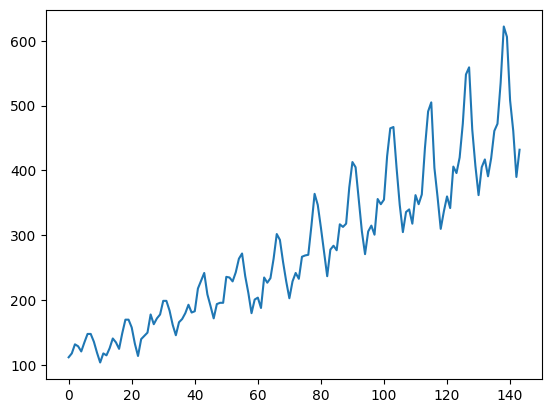

In [5]:
df_log = plt.plot(df)
plt.show(df_log)

In [6]:
def check_stationarity(timeseries):
    
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Dickey-Fuller Test Results:')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(df_output)

*Purpose:* This function checks the stationarity of the time series. It calculates and plots the rolling mean and standard deviation to visualize any trends or seasonality. The Dickey-Fuller test is performed to statistically determine if the series is stationary.

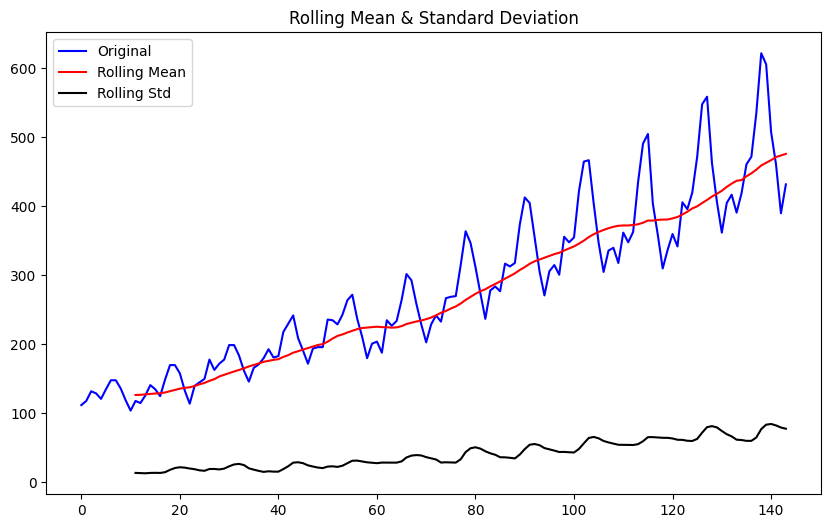

Dickey-Fuller Test Results:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
check_stationarity(df)

In [8]:
print(type(df))

<class 'pandas.core.series.Series'>


In [9]:
df = df.to_frame()
print(df.columns)

Index(['passengers'], dtype='object')


In [10]:
# lets create a date column with a monthly end frequency starting from January 1949. 
# This enables time-based indexing for the DataFrame, essential for time series analysis.
df['Date'] = pd.date_range(start='1949-01-01', periods=len(df), freq='ME')

In [11]:
decomposition_result = seasonal_decompose(df["passengers"], model="additive", period=12) 

fig = make_subplots(rows=4, cols=1, subplot_titles=("Original Series", "Trend Component", "Seasonal Component", "Residuals"))

fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.observed, mode="lines", name="Original", line=dict(color="darkblue")), row=1, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.trend, mode="lines", name="Trend", line=dict(color="green")), row=2, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.seasonal, mode="lines", name="Seasonality", line=dict(color="purple")), row=3, col=1)
fig.add_trace(go.Scatter(x=df["Date"], y=decomposition_result.resid, mode="lines", name="Residuals", line=dict(color="orange")), row=4, col=1)

fig.update_layout(title="Decomposition of Time Series", height=900, showlegend=False, plot_bgcolor="whitesmoke")

animation_frames = []
for i in range(len(df)):
    frame = go.Frame(data=[go.Scatter(x=df["Date"][:i+1], y=decomposition_result.observed[:i+1], mode="lines", name="Original", line=dict(color="darkblue")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.trend[:i+1], mode="lines", name="Trend", line=dict(color="green")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.seasonal[:i+1], mode="lines", name="Seasonality", line=dict(color="purple")),
                            go.Scatter(x=df["Date"][:i+1], y=decomposition_result.resid[:i+1], mode="lines", name="Residuals", line=dict(color="orange"))],
                      traces=[0, 1, 2, 3])
    animation_frames.append(frame)

fig.frames = animation_frames

fig.update_layout(updatemenus=[dict(type="buttons", showactive=False,
                                    buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration": 400, "redraw": True}, "fromcurrent": True, "mode": "immediate"}]),
                                             dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])])])

fig.show()

The code above is written to facilitate the understanding and visualization of components in time series analysis. By observing the time series, trends, seasonality, and residuals, we can better comprehend the dynamics of the data. The animation allows these changes to be presented in a more interactive and comprehensible manner.

In [12]:
df_log = np.log(df["passengers"])

df_log_diff = df_log - df_log.shift()

# This will apply a logarithmic transformation to the passengers' data to stabilize the variance and reduce the impact of extreme values (outliers).

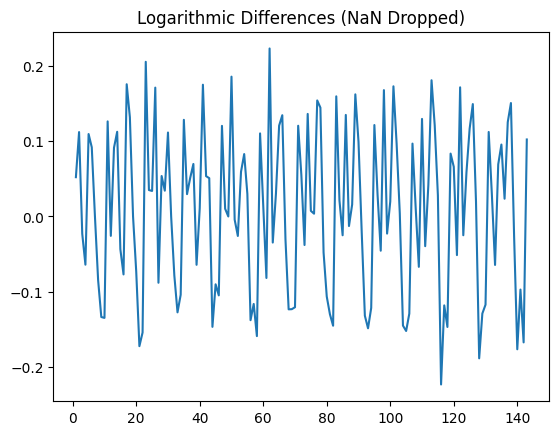

In [13]:
plt.plot(df_log_diff.dropna())
plt.title("Logarithmic Differences (NaN Dropped)")
plt.show()

#This visualization displays the log differences, allowing us to observe the changes in the series over time and assess whether it appears stationary after differencing.

In [14]:
df_log_diff = df_log_diff.dropna()

# Data Preprocessing

In [16]:
print(df.columns)

Index(['passengers', 'Date'], dtype='object')


In [17]:
df = df.drop(columns=['Date'])

In [18]:
type(df) #I need 2D array for MinMaxScaler() and my other methods to work. So I will change to numpy array and reshape it.

pandas.core.frame.DataFrame

In [19]:
df = np.array(df).reshape(-1,1)

In [20]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

## Train-Test Split

In [21]:
len(df)

144

In [22]:
train = df[0:100,:]
test = df [100:,:]

In [23]:
def get_data(df, steps):      
    dataX = []
    dataY = []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps, 0])
    return np.array(dataX), np.array(dataY)

# This function is written to prepare the training set.

In [24]:
steps = 2

In [25]:
X_train, y_train = get_data(train, steps)
X_test, y_test = get_data(test, steps)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM Model

In [27]:
LSTMmodel = Sequential()
LSTMmodel.add(Input(shape=(1, steps)))  

LSTMmodel.add(LSTM(128, return_sequences=True)) 
LSTMmodel.add(Dropout(0.2))  

LSTMmodel.add(LSTM(64))
LSTMmodel.add(Dropout(0.2))

LSTMmodel.add(Dense(32, activation="relu"))
LSTMmodel.add(Dense(1))  

LSTMmodel.compile(loss='mean_squared_error', optimizer='adam')

In [28]:
LSTMmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

LSTMmodel.fit(X_train, y_train, 
          epochs=100, 
          batch_size=16, 
          validation_split=0.1, 
          callbacks=[early_stop, reduce_lr], 
          verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0523 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0393 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0104 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━━━━

In [30]:
y_pred = LSTMmodel.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


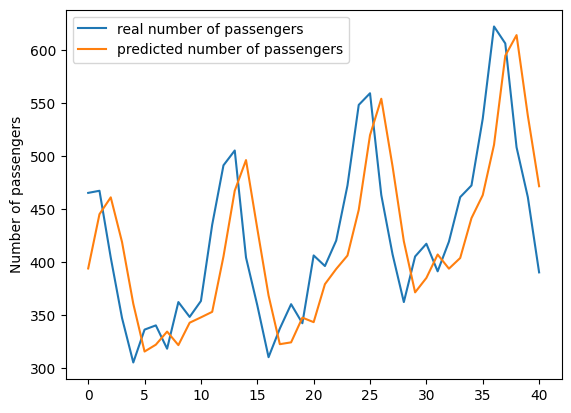

In [31]:
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('Months')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

In [32]:
def plot_prediction(y_true, y_pred, sample_size=100):
    sample_size = min(len(y_true), sample_size)

    indices = np.random.choice(range(len(y_true)), size=sample_size, replace=False)
    y_true_sample = y_true[indices]
    y_pred_sample = y_pred[indices]

    plt.figure(figsize=(10, 6))

    plt.plot(y_true_sample, label="Actual Values", marker='o', color='b')

    plt.plot(y_pred_sample, label="Predicted Values", marker='x', color='r')

    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

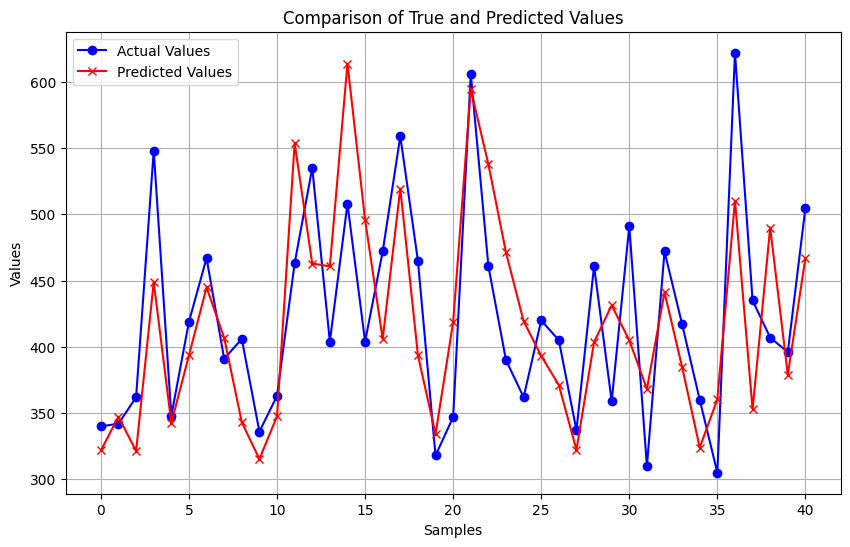

In [33]:
plot_prediction(y_test, y_pred)

In [34]:
## Any kind of feedback will be appreciated. Thank you